<a href="https://colab.research.google.com/github/DJBHARATH/Face-emotion-recognition/blob/main/Copy_of_Face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras.layers import Dense
warnings.filterwarnings(action='ignore')

from tensorflow.keras.utils import to_categorical

In [1]:
!pip install -U scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau,Callback,TensorBoard
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Flatten,Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D, SeparableConv2D,Input, GlobalAveragePooling2D,concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**EDA**

In [7]:
data_df= pd.read_csv('/content/drive/My Drive/Almabetter projects/Face emotion recognition/FER2013.csv')

In [8]:
data_df.shape

(35887, 3)

In [9]:
data_df.isnull().sum()


emotion    0
pixels     0
Usage      0
dtype: int64

In [10]:
EmotionCode={0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


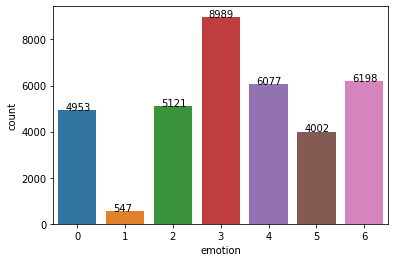

In [11]:
#emotion counts
ax = sns.countplot(x="emotion", data=data_df)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.01))

plt.show()

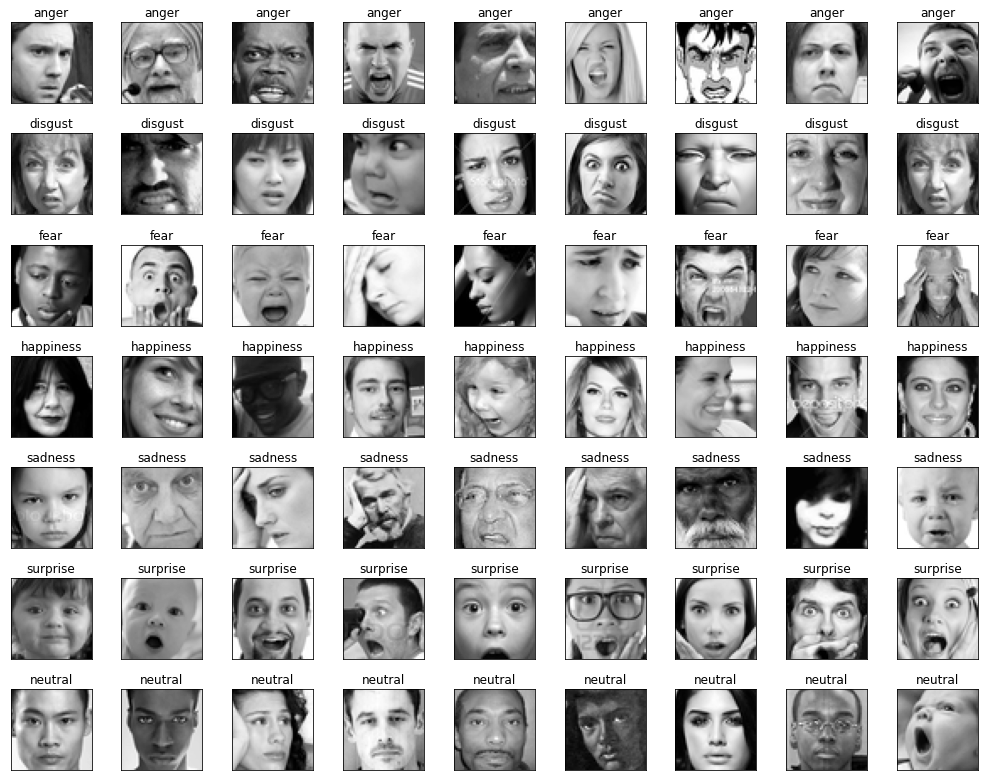

In [12]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(data_df.emotion.unique()):
    for j in range(9):
        px = data_df[data_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float64')

        k += 1
        ax = plt.subplot(9, 9, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(EmotionCode[label])
        plt.tight_layout()

In [13]:
batch_size = 32
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
shape_x = 48
shape_y = 48
image_size=(48,48)

In [14]:
data_df['pixels']=data_df['pixels'].astype("string")
pixels = data_df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(data_df['emotion']).to_numpy()

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(faces,emotions,
                                                    shuffle=True,
                                                    test_size=0.2, random_state=42)
train_data,test_data,train_labels,test_labels=train_test_split(faces,emotions,test_size=0.2,shuffle=True)
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape,test_data.shape,test_data.shape

((28709, 48, 48, 1),
 (7178, 48, 48, 1),
 (28709, 7),
 (7178, 7),
 (7178, 48, 48, 1),
 (7178, 48, 48, 1))

In [16]:
TrainDataGen = ImageDataGenerator(
    rotation_range=15,         
    width_shift_range=0.15,    
    height_shift_range=0.15,   
    shear_range=0.15,
    zoom_range=0.15,           
    horizontal_flip=True,      
)
TrainDataGen.fit(train_data)

In [17]:
model_path= "/content/drive/MyDrive/almabetter projects/Face emotion recognition/"


1.CNN model

In [18]:
# Building up Model Architecture
def CNN():
    model = Sequential()

    #1st CNN layer
    model.add(Conv2D(64,(3,3),padding = 'same', name='image_array', input_shape = (48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    #2nd CNN layer
    model.add(Conv2D(128,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #3rd CNN layer
    model.add(Conv2D(512,(3,3),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #4th CNN layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Fully connected 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [19]:
CNN=CNN()

In [20]:
opt = optimizers.Adam(learning_rate=0.001) #using Adam Optimizer
CNN.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = model_path + 'cnn'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [22]:
CNN_history =CNN.fit(TrainDataGen.flow(train_data,train_labels, batch_size),
          steps_per_epoch=len(train_data) / batch_size, 
          epochs= 100, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(test_data,test_labels))

Epoch 1/100
896/897 [============================>.] - ETA: 0s - loss: 1.8659 - accuracy: 0.2559
Epoch 1: val_loss improved from inf to 1.77489, saving model to /content/drive/MyDrive/almabetter projects/Face emotion recognition/cnn.01-0.33.hdf5
897/897 [==============================] - 42s 31ms/step - loss: 1.8655 - accuracy: 0.2561 - val_loss: 1.7749 - val_accuracy: 0.3274 - lr: 0.0010
Epoch 2/100
896/897 [============================>.] - ETA: 0s - loss: 1.6066 - accuracy: 0.3728
Epoch 2: val_loss improved from 1.77489 to 1.48631, saving model to /content/drive/MyDrive/almabetter projects/Face emotion recognition/cnn.02-0.45.hdf5
897/897 [==============================] - 24s 27ms/step - loss: 1.6064 - accuracy: 0.3728 - val_loss: 1.4863 - val_accuracy: 0.4461 - lr: 0.0010
Epoch 3/100
898/897 [==============================] - ETA: 0s - loss: 1.4343 - accuracy: 0.4459
Epoch 3: val_loss improved from 1.48631 to 1.45102, saving model to /content/drive/MyDrive/almabetter projects/Face

In [23]:
CNN.save('/content/drive/MyDrive/almabetter projects/Face emotion recognition/CNN.h5')

#2.RESNET



In [ ]:
IW = train_data.shape[1]
img_height = train_data.shape[2]
img_depth = train_data.shape[3]
num_classes = train_labels.shape[1]

In [ ]:
#Function for building the Residual network 
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used 'ELU' as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. 'he_normal' kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(IW, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = model_path + 'resnet'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [ ]:
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [ ]:
ResNet = build_net(optims[1])

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:
resnet_history =ResNet.fit(TrainDataGen.flow(train_data,train_labels, batch_size),
          steps_per_epoch=len(train_data) / batch_size, 
          epochs= 100, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(test_data,test_labels))

Epoch 1/100
897/897 [============================>.] - ETA: 0s - loss: 2.0716 - accuracy: 0.2376
Epoch 1: val_loss improved from inf to 1.65115, saving model to /content/drive/MyDrive/almabetter projects/Face emotion recognition/resnet.01-0.35.hdf5
897/897 [==============================] - 33s 26ms/step - loss: 2.0713 - accuracy: 0.2377 - val_loss: 1.6512 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 2/100
897/897 [============================>.] - ETA: 0s - loss: 1.6737 - accuracy: 0.3370
Epoch 2: val_loss improved from 1.65115 to 1.46350, saving model to /content/drive/MyDrive/almabetter projects/Face emotion recognition/resnet.02-0.43.hdf5
897/897 [==============================] - 25s 28ms/step - loss: 1.6734 - accuracy: 0.3371 - val_loss: 1.4635 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 3/100
898/897 [==============================] - ETA: 0s - loss: 1.5163 - accuracy: 0.4113
Epoch 3: val_loss improved from 1.46350 to 1.36429, saving model to /content/drive/MyDrive/almabetter project

In [ ]:
ResNet.save('/content/drive/MyDrive/almabetter projects/Face emotion recognition/ResNet.h5')


#3.Densenet

In [ ]:
#optimizers,learning rate,loss and metrics for DenseNet model
DenseNet121 = DenseNet121(input_shape=[48,48]+ [1], weights=None, include_top=True,classes=7)
dense_net_model = Model(inputs=DenseNet121.input, outputs=DenseNet121.output)
dense_opt= optimizers.Adam(learning_rate=0.01) #using Adam Optimizer
dense_net_model.compile(optimizer=dense_opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = model_path + 'densenet'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [ ]:
dense_net_history =dense_net_model.fit(TrainDataGen.flow(train_data, train_labels, batch_size),
          steps_per_epoch=len(train_data) / batch_size, 
          epochs=100, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(test_data,test_labels))

Epoch 1/100
898/897 [==============================] - ETA: 0s - loss: 1.9917 - accuracy: 0.2422
Epoch 1: val_loss improved from inf to 1.80029, saving model to /content/drive/MyDrive/almabetter projects/Face emotion recognition/densenet.01-0.26.hdf5
897/897 [==============================] - 91s 78ms/step - loss: 1.9917 - accuracy: 0.2422 - val_loss: 1.8003 - val_accuracy: 0.2644 - lr: 0.0100
Epoch 2/100
898/897 [==============================] - ETA: 0s - loss: 1.7836 - accuracy: 0.2568
Epoch 2: val_loss improved from 1.80029 to 1.78129, saving model to /content/drive/MyDrive/almabetter projects/Face emotion recognition/densenet.02-0.28.hdf5
897/897 [==============================] - 64s 71ms/step - loss: 1.7836 - accuracy: 0.2568 - val_loss: 1.7813 - val_accuracy: 0.2772 - lr: 0.0100
Epoch 3/100
898/897 [==============================] - ETA: 0s - loss: 1.7520 - accuracy: 0.2728
Epoch 3: val_loss did not improve from 1.78129
897/897 [==============================] - 58s 64ms/step -

In [ ]:
dense_net_model.save('/content/drive/MyDrive/almabetter projects/Face emotion recognition/DenseNet.h5')


#**Evaluation Metrics**

#CNN Accuracy



In [24]:
#checking accuracy CNN model
predicted_test_labels = np.argmax(CNN.predict(test_data), axis=1)

225/225 [==============================] - 2s 7ms/step


In [25]:
test_labels = np.argmax(test_labels, axis=1)

In [26]:
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))


Accuracy score =  0.6827807188631931


#ResNet accuracy



In [ ]:
predicted_test_labels = np.argmax(ResNet.predict(test_data), axis=1)

225/225 [==============================] - 2s 7ms/step


In [ ]:
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))

Accuracy score =  0.6823627751462803


#Densenet accuracy

In [ ]:
#checking accuracy Densenet Model
predicted_test_labels = np.argmax(dense_net_model.predict(test_data), axis=1)

225/225 [==============================] - 5s 14ms/step


In [ ]:
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))


Accuracy score =  0.6533853441069936


In [27]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 128)       2

#CNN is the best model with

##Confusion Matrix



In [28]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(EmotionCode))
    ax.set_xticks(ticks)
    ax.set_xticklabels(EmotionCode, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(EmotionCode)
    plt.tight_layout()
    plt.ylabel('True emotion')
    plt.xlabel('Predicted emotion')

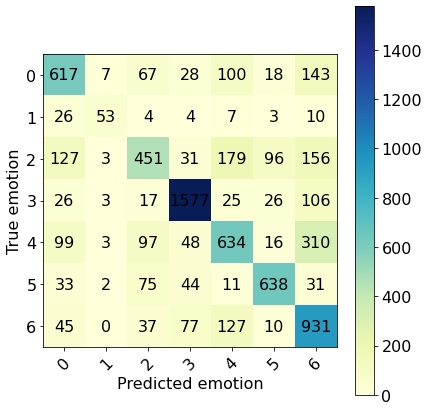

In [29]:
plot_confusion_matrix(test_labels, predicted_test_labels, cmap=plt.cm.YlGnBu)
plt.show()


#Classification report

In [ ]:
predictions = ResNet.predict(test_data)
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1)))

#Defining Function to crop face and analyszing photo taken

In [30]:
from IPython.display import display, Javascript, Image,clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [31]:
fer_json = CNN.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
CNN.save_weights("fer.h5")

In [32]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [33]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


In [34]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [35]:
# Defining function to detect face
def face_detect():
  import cv2
  from PIL import Image
  import numpy as np
  import os
  from keras.models import load_model
  from time import sleep
  from tensorflow.keras.preprocessing.image import img_to_array
  from keras.preprocessing import image
# start streaming video from webcam
  video_stream()
# label for video
  label_html = 'Capturing...'
# initialze bounding box to empty
  bbox = ''
  count = 0
  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Face Detection
  classifier =load_model('/content/drive/MyDrive/almabetter projects/Face emotion recognition/CNN.h5')  #Load model
  emotion_labels = ['Angry','Disgust','Fear','Happy','sad', 'Surprise', 'neutral'] 

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
      roi_gray = gray[y:y+h,x:x+w]
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction
      if np.sum([roi_gray])!=0:
        roi = roi_gray.astype('float')/255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction
        prediction = classifier.predict(roi)[0]   #Prediction
        label=emotion_labels[prediction.argmax()]
        label_position = (x,y)
        cv2.putText(bbox_array,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)   # Text Adding
      else:
        cv2.putText(bbox_array,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
     


In [ ]:
face_detect()
